In [2]:
if True:
    import os
    os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'
    execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))
    import os
    import sys
else:
    os.environ['SPARK_HOME'] = '/usr/lib/spark'
    sys.path.insert(0, '/usr/lib/spark/python/lib/py4j-0.9-src.zip')
    sys.path.insert(0, '/usr/lib/spark/python/')
    sys.path.insert(0, '/usr/local/lib64/python2.7/site-packages')
    sys.path.insert(0,'/usr/local/lib/python2.7/site-packages')
    
    from pyspark import SparkContext
    from pyspark.sql import SQLContext, HiveContext
    
    try: sc = SparkContext()
    except: None    
    sqlc = SQLContext(sc)
    spark = sqlc

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import seaborn as sns

In [7]:
import numpy as np
import pandas as pd
import time
import json

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, MapType
import pyspark.sql.functions as F

In [8]:
from operator import add
from pyspark.sql.types import *

In [9]:
from pyspark.mllib.recommendation import Rating
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel
from datetime import datetime

In [10]:
import sklearn.metrics.pairwise as sk_pairwise
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
import heapq
from random import sample

In [11]:
import multiprocessing as mp
import cPickle as pickle

# Load model

In [12]:
model = MatrixFactorizationModel.load(sc,"lab_12/cache/als40_full_ratings.model")

In [13]:
user_fct = model.userFeatures()

In [14]:
user_fct.count()

227211

# Get all vectors to driver

In [15]:
user_lst = user_fct.collect()

In [16]:
len(user_lst)

227211

In [17]:
user_lst[0]

(4,
 array('d', [0.30437615513801575, 0.23109781742095947, 0.757438063621521, 0.05556928738951683, 0.315228670835495, 0.3392287790775299, 0.03952641785144806, 0.15768186748027802, 0.20846892893314362, 0.03663899004459381, 0.2956579029560089, 0.029475567862391472, -0.08807317167520523, -0.058803316205739975, -0.20378635823726654, -0.29701197147369385, -0.3306105136871338, -0.6271849870681763, 0.38384172320365906, 0.011928347870707512, -0.22439442574977875, 0.3711453378200531, 0.01539056096225977, -0.13775993883609772, 0.13029120862483978, -0.742336630821228, 0.13999181985855103, 0.3101981580257416, -0.05420177802443504, -0.4345110058784485, -0.5009539723396301, -0.07760768383741379, 0.07148448377847672, -0.37589943408966064, 0.5898971557617188, 0.20991501212120056, 0.35189899802207947, -0.022415626794099808, -0.32871684432029724, -0.6028376817703247]))

# Build similarity matrix

In [18]:
all_vecs = [r[1] for r in user_lst]
user_ids = [r[0] for r in user_lst]

In [19]:
user_mx = np.vstack(all_vecs)

In [20]:
del all_vecs
del user_lst

In [21]:
user_mx.shape

(227211, 40)

In [22]:
# tooooo big for np
#%%time
#u2u_sim = sk_pairwise.cosine_similarity(user_mx)

# Find topK similar within clusters

In [10]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [11]:
def vsplit(mx, vec, n_splits):
    idx = np.array(range(mx.shape[0]))
    res = []
    for i in range(n_splits):
        c_idx = (idx % n_splits) == i
        mx_block = mx[c_idx,:]
        vec_block = vec[c_idx]
        res.append((mx_block, vec_block))
    return res    

In [12]:
def top_k_in_block_worker(r):
    cb_mx, cb_user_ids, all_user_ids, k_neighbors = r
    records = []
    for j in range(cb_mx.shape[0]):
        j_id = cb_user_ids[j]
        j_topk = heapq.nlargest(k_neighbors + 1, enumerate(cb_mx[j,:]), lambda x: x[1])[1:]
        j_topk_ids = [(j_id, all_user_ids[s], js_sim, sim_rank) for sim_rank,(s,js_sim) in enumerate(j_topk)]
        records.extend(j_topk_ids)  
    return records    

In [26]:
n_proc = 7
pool = mp.Pool(n_proc)

In [27]:
user_mx_norm = normalized(user_mx)

In [28]:
user_ids_arr = np.array(user_ids)

In [29]:
k_neighbors = 100

In [ ]:
#cseed=42
#cseed=268
cseed=68
for n_clusters in [7,8]:
    print datetime.now(), '============= n_clusters:', n_clusters
    km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=cseed, n_jobs=6)
    
    clusters = km.fit_predict(user_mx_norm)
    ucdf = pd.DataFrame.from_dict({'user':user_ids, 'cluster':clusters})
    print ucdf.groupby('cluster')['user'].agg(len)
    ucdf.to_csv("/data/home/taras.svirsky/lab12/tmp/u_cluster_n%d_rs%d.csv" % (n_clusters, cseed))
    
    print '## Finding neighbors within clusters'
    for cluster in range(n_clusters):
        fpath = "/data/home/taras.svirsky/lab12/tmp/u2u_top%d_in_cluster_%d_from_%d_rs%d.csv" % (k_neighbors, cluster, n_clusters, cseed)
        if os.path.exists(fpath):
            print 'has cached', fpath
            continue
        cluster_idx = clusters == cluster
        c_user_mx = user_mx[cluster_idx, :]
        c_user_ids = user_ids_arr[cluster_idx]
        print datetime.now(), 'working on cluster', cluster, 'size', c_user_mx.shape
        #if cluster == 5:
        #    break
        c_u2u_sim = sk_pairwise.cosine_similarity(c_user_mx)  
        print datetime.now(), 'u2u sim calculated' 

        # !!! sequential version
        #records = []
        #for j in range(len(c_user_ids)):
        #    j_id = c_user_ids[j]
        #    j_topk = heapq.nlargest(k_neighbors + 1, enumerate(c_u2u_sim[j,:]), lambda x: x[1])[1:]
        #    j_topk_ids = [(j_id, c_user_ids[s], js_sim, sim_rank) for sim_rank,(s,js_sim) in enumerate(j_topk)]
        #    records.extend(j_topk_ids)
        #    if j % 1000 == 0:
        #        print datetime.now(), cluster, j

        # !!!! parallel version
        blocks = vsplit(c_u2u_sim, c_user_ids, 30)
        tasks = [(t[0], t[1], c_user_ids, k_neighbors) for t in blocks]
        del blocks
        del c_u2u_sim
        records_per_block = pool.map(top_k_in_block_worker, tasks, 1)
        del tasks
        records = []
        for b in records_per_block:
            records.extend(b)
        print datetime.now(), 'topK found for all users within cluster'   
        
        # dump results
        top_k_df = pd.DataFrame.from_records(records, columns=['user1', 'user2', 'similarity', 'sim_rank'])   
        top_k_df.to_csv(fpath, index=False)

2016-12-25 12:12:58.130785 ============= n_clusters: 7
cluster
0    31027
1    31668
2    39146
3    30640
4    32792
5    33636
6    28302
Name: user, dtype: int64
## Finding neighbors within clusters
2016-12-25 12:13:22.357872 working on cluster 0 size (31027, 40)
2016-12-25 12:13:42.338158 u2u sim calculated
2016-12-25 12:16:46.840604 topK found for all users within cluster
2016-12-25 12:16:57.957199 working on cluster 1 size (31668, 40)
2016-12-25 12:17:18.726221 u2u sim calculated
2016-12-25 12:20:22.909021 topK found for all users within cluster
2016-12-25 12:20:34.388742 working on cluster 2 size (39146, 40)
2016-12-25 12:21:06.357804 u2u sim calculated
2016-12-25 12:25:42.282535 topK found for all users within cluster
2016-12-25 12:25:56.399257 working on cluster 3 size (30640, 40)
2016-12-25 12:26:15.733956 u2u sim calculated
2016-12-25 12:47:15.433929 topK found for all users within cluster
2016-12-25 12:47:25.039743 working on cluster 3 size (31798, 40)
2016-12-25 12:47:45.8

In [ ]:
pool.close()
pool.terminate()
pool.join()

# Merge all u2u similarities from different clusterings

In [14]:
data_root="/data/home/taras.svirsky/lab12/tmp"
df_list = []
for f in sorted(os.listdir(data_root)):
    if not f.startswith("u2u_top"):
        continue 
    sdf = pd.read_csv(os.path.join(data_root, f))
    del sdf['sim_rank']
    df_list.append(sdf)

In [15]:
sdf = pd.concat(df_list)

In [16]:
sdf.shape

(154373400, 3)

In [18]:
q=sdf.drop_duplicates()

In [19]:
q.shape

(36589720, 3)

In [20]:
sdf = q

In [22]:
q=sdf.groupby(['user1','user2']).mean().reset_index()

In [23]:
q.shape

(36589691, 3)

In [24]:
sdf=q

In [25]:
sdf.head()

,user1,user2,similarity
0,1,443,0.929503
1,1,2714,0.921492
2,1,3999,0.919720
3,1,4134,0.924081
4,1,5849,0.922867


In [27]:
sdf=sdf.sort_values(by=['user1','similarity'], ascending=[1,0])

In [32]:
sdf['sim_rank'] = sdf.groupby(['user1']).cumcount()

In [36]:
zz=sdf.groupby("user1")['sim_rank'].max()

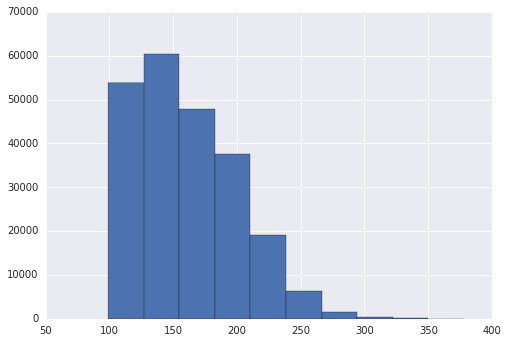

In [43]:
zz.hist()

In [39]:
sdf=sdf[sdf.sim_rank<=200]

In [40]:
sdf.shape

(35611329, 4)

In [42]:
sdf.to_csv("/data/home/taras.svirsky/lab12/data/u2u_top100to200.csv", index=False)